# Import all relevant libraries

*Add information about each of the libraries and why we are importing them

In [23]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
import datetime
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from matplotlib import pyplot as plt
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

# Extracting the Dugong Dataset

The dataset was downloaded as a csv file from the QLD open data portal (https://www.data.qld.gov.au/dataset/marine-strandings) anduploaded into the Jupyter notebook. 

Here we read the data and remove non values

In [14]:
# Reading the data
dugong_df = pd.read_csv('dugong-strandings.csv')

# Remove all rows with Nan values
dugong = dugong_df[dugong_df['Location'].notna()]

# Set the index to Location
dugong.set_index('Location', inplace=True)

# View dataframe
dugong

,2014,2013,2012,2011,2010
Location,,,,,
Moreton Bay,7,7,6,16,14
Hervey Bay,1,5,6,19,6
Rockhampton,1,2,8,10,3
Mackay,1,0,1,4,1
Townsville,2,3,4,51,16
Cairns,0,2,5,11,16
Remainder of east coast,11,8,14,55,12


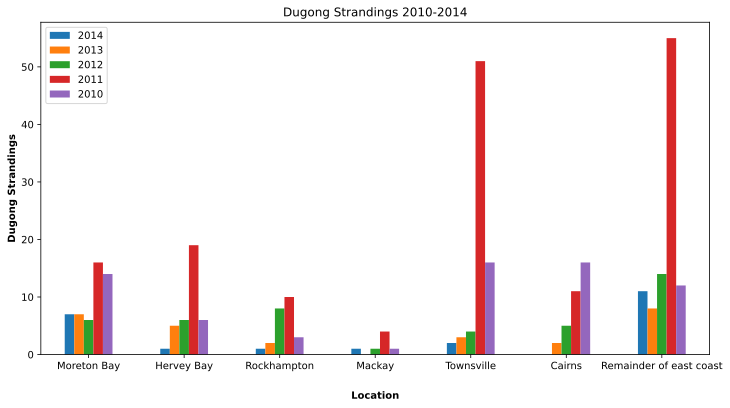

In [15]:
# Plotting dugong strandings and adding axis labels
dugong.plot(kind='bar', figsize=(12,6))
plt.title('Dugong Strandings 2010-2014')
plt.xlabel('Location', labelpad=20, weight='bold')
plt.ylabel('Dugong Strandings', weight='bold')

# Rotating x ticks to display them horizontally and saving and showing the plot           
plt.xticks(rotation=0)
plt.savefig('Dugong Strandings 2010-2014')
plt.show()

# Extracting data from eReefs

Selecting a site and year to extract eg the Hervey Bay site for the year 2011

In [2]:
# Site information name and position
siteName = 'HerveyBay'
siteLon =  125.7
siteLat = -25.2

# Bounding box resolution (in degrees)
bb_res = 1.

# Year
year = 2011

Setting extraction from eReefs Biogeochemical dataset

In [3]:
base_url = "http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/GBR4_H2p0_B3p1_Cq3b_Dhnd/daily-monthly/EREEFS_AIMS-CSIRO_GBR4_H2p0_B3p1_Cq3b_Dhnd_bgc_daily-monthly-"   


Extracting data for given region for an entire year for earch variable. 
Note this will take time to run

In [4]:
bounding_box = [siteLon-bb_res/2.,siteLat-bb_res/2.,siteLon+bb_res/2.,siteLat+bb_res/2.]

for k in range(1,13):

    print('Save dataset for month: ', k)
    biofiles = [f"{base_url}{year}-{month:02}.nc" for month in range(k, k+1)]

# Selecting eReefs data

    ds_bio = xr.open_mfdataset(biofiles, chunks={'time': '100MB'})
    
# Selecting specific variables from eReefs

    nitro = ds_bio.TOTAL_NITROGEN
    nitro = nitro.sel(method='nearest')
    temp = ds_bio.temp
    temp = temp.sel(method='nearest')
    salinity = ds_bio.salt
    salinity = salinity.sel(method='nearest')
    light = ds_bio.EpiPAR_sg
    light = light.sel(method='nearest')
    seagrass = ds_bio.SG_N
    seagrass = seagrass.sel(method='nearest')
    
# Selecting variables for the depth of 10m
    
    surf_nitro = nitro.sel(k=slice(11,-1))
    mask_lon3 = (surf_nitro.longitude >= bounding_box[0]) & (surf_nitro.longitude <= bounding_box[2])
    mask_lat3 = (surf_nitro.latitude >= bounding_box[1]) & (surf_nitro.latitude <= bounding_box[3])
    moreton_nitro = surf_nitro.where(mask_lon3 & mask_lat3, drop=True)
    moreton_nitro_mean = moreton_nitro.mean(dim='k',skipna=True)
    
    surf_temp = temp.sel(k=slice(11,-1))
    mask_lon4 = (surf_temp.longitude >= bounding_box[0]) & (surf_temp.longitude <= bounding_box[2])
    mask_lat4 = (surf_temp.latitude >= bounding_box[1]) & (surf_temp.latitude <= bounding_box[3])
    moreton_temp = surf_temp.where(mask_lon4 & mask_lat4, drop=True) 
    moreton_temp_mean = moreton_temp.mean(dim='k',skipna=True)
    
    surf_salinity = salinity.sel(k=slice(11,-1))
    mask_lon5 = (surf_salinity.longitude >= bounding_box[0]) & (surf_salinity.longitude <= bounding_box[2])
    mask_lat5 = (surf_salinity.latitude >= bounding_box[1]) & (surf_salinity.latitude <= bounding_box[3])
    moreton_salinity = surf_salinity.where(mask_lon5 & mask_lat5, drop=True)
    moreton_salinity_mean = moreton_salinity.mean(dim='k',skipna=True)
    
    mask_lon6 = (light.longitude >= bounding_box[0]) & (light.longitude <= bounding_box[2])
    mask_lat6 = (light.latitude >= bounding_box[1]) & (light.latitude <= bounding_box[3])
    moreton_light = light.where(mask_lon6 & mask_lat6, drop=True)
    
    mask_lon7 = (seagrass.longitude >= bounding_box[0]) & (seagrass.longitude <= bounding_box[2])
    mask_lat7 = (seagrass.latitude >= bounding_box[1]) & (seagrass.latitude <= bounding_box[3])
    moreton_seagrass = seagrass.where(mask_lon7 & mask_lat7, drop=True) 
    
# Loading varibles into data array

    loadnitro = moreton_nitro_mean.load()
    loadtemp = moreton_temp_mean.load()
    loadsalinity = moreton_salinity_mean.load()
    loadlight = moreton_light.load()
    loadseagrass = moreton_seagrass.load()
    
    site_ds = loadnitro.to_dataset() 
    site_ds["temp"] = (['time', 'latitude', 'longitude'],  loadtemp.values) 
    site_ds["salinity"] = (['time', 'latitude', 'longitude'],  loadsalinity.values) 
    site_ds["light"] = (['time', 'latitude', 'longitude'],  loadlight.values) 
    site_ds["seagrass"] = (['time', 'latitude', 'longitude'],  loadseagrass.values) 
    
    site_ds.to_netcdf(siteName+'_'+str(k)+'_'+str(year)+'.nc')

Save dataset for month:  1
Save dataset for month:  2
Save dataset for month:  3
Save dataset for month:  4
Save dataset for month:  5
Save dataset for month:  6
Save dataset for month:  7
Save dataset for month:  8
Save dataset for month:  9
Save dataset for month:  10
Save dataset for month:  11
Save dataset for month:  12


Loading the year file to the notebook eg 2011

In [5]:
dsyear = xr.open_mfdataset('HerveyBay_*_2011.nc')

dsyear.to_netcdf('HerveyBay2011.nc')

HerveyBay2011 = xr.open_dataset('HerveyBay2011.nc')
HerveyBay2011

<xarray.Dataset>
Dimensions:         (time: 365, latitude: 0, longitude: 0)
Coordinates:
  * time            (time) datetime64[ns] 2011-01-01T02:00:00 ... 2011-12-31T...
  * latitude        (latitude) float64 
  * longitude       (longitude) float64 
Data variables:
    TOTAL_NITROGEN  (time, latitude, longitude) float32 ...
    temp            (time, latitude, longitude) float32 ...
    salinity        (time, latitude, longitude) float32 ...
    light           (time, latitude, longitude) float32 ...
    seagrass        (time, latitude, longitude) float32 ...

From this dataset you can see that there are 5 data variables: Total Nitrogen, Temperature, Salinity, Light and Seagrass for the year 2011. 

This needs to be repeated for each year 

Once all the years for a site have been completed, they can be loaded into a single data set. 

We created a folder called HereyBay on our notebook where we will be extracting the data from so the pathway to combine our data is as below:

In [24]:
HerveyBay = xr.open_mfdataset('HerveyBay/HerveyBay*.nc')

HerveyBay

<xarray.Dataset>
Dimensions:         (time: 1461, latitude: 33, longitude: 34)
Coordinates:
  * time            (time) datetime64[ns] 2011-01-01T02:00:00 ... 2014-12-31T...
  * latitude        (latitude) float64 -25.79 -25.76 -25.73 ... -24.86 -24.83
  * longitude       (longitude) float64 152.3 152.3 152.4 ... 153.2 153.3 153.3
Data variables:
    TOTAL_NITROGEN  (time, latitude, longitude) float32 dask.array<chunksize=(365, 33, 34), meta=np.ndarray>
    temp            (time, latitude, longitude) float32 dask.array<chunksize=(365, 33, 34), meta=np.ndarray>
    salinity        (time, latitude, longitude) float32 dask.array<chunksize=(365, 33, 34), meta=np.ndarray>
    light           (time, latitude, longitude) float32 dask.array<chunksize=(365, 33, 34), meta=np.ndarray>
    seagrass        (time, latitude, longitude) float32 dask.array<chunksize=(365, 33, 34), meta=np.ndarray>

You can see this is a data array containing the desired variables across the years. This process needs to be completed for each site of interest

## Extracting the Cyclone Data

To extract cyclone data from the dataset that is relevant to our area of study, we first need to determine the relevant cyclone basin.  
The [metadata](https://www.ncei.noaa.gov/sites/default/files/2021-07/IBTrACS_v04_column_documentation.pdf) of the [NOAA IBTrACS cyclones](https://www.ncdc.noaa.gov/ibtracs/index.php?name=ibtracs-data) dataset that we will use provides the following basin key:  

**Basin Key:**

* NA - North Atlantic
* EP - Eastern North Pacific
* WP - Western North Pacific
* NI - North Indian
* SI - South Indian
* SP - Southern Pacific
* SA - South Atlantic

Since the region we are exploring is the GBR, we will be looking at the cyclones of the Southern Pacific (SP) basin.

The following is the code to load the CSV file of the [NOAA IBTrACS cyclones](https://www.ncdc.noaa.gov/ibtracs/index.php?name=ibtracs-data) dataset for the South Pacific basin:

In [6]:
#url = https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/csv/ibtracs.SP.list.v04r00.csv
url = 'ibtracs.SP.list.v04r00.csv'
df = pd.read_csv(url, parse_dates=['ISO_TIME'], usecols=range(12), index_col='SID',
                 skiprows=[1], na_values=[' ', 'NOT_NAMED'],
                 keep_default_na=False, dtype={'NAME': str})
df

,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,WMO_WIND,WMO_PRES
SID,,,,,,,,,,,
1897005S10135,1897,1,SP,EA,NaN,1897-01-04 12:00:00,NR,-10.1000,135.300,NaN,NaN
1897005S10135,1897,1,SI,WA,NaN,1897-01-04 15:00:00,NR,-10.2755,134.902,NaN,NaN
1897005S10135,1897,1,SI,WA,NaN,1897-01-04 18:00:00,NR,-10.4406,134.523,NaN,NaN
1897005S10135,1897,1,SI,WA,NaN,1897-01-04 21:00:00,NR,-10.5853,134.182,NaN,NaN
1897005S10135,1897,1,SI,WA,NaN,1897-01-05 00:00:00,NR,-10.7000,133.900,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022139S15169,2022,27,SP,MM,GINA,2022-05-21 18:00:00,NR,-20.6000,171.100,NaN,NaN
2022139S15169,2022,27,SP,MM,GINA,2022-05-21 21:00:00,NR,-20.5147,171.309,NaN,NaN
2022139S15169,2022,27,SP,MM,GINA,2022-05-22 00:00:00,NR,-20.5000,171.500,NaN,NaN


In [7]:
# Here, all rows with NaN values in WMO_WIND column are removed
df2 = df[df["WMO_WIND"].notna()]
df2

,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,WMO_WIND,WMO_PRES
SID,,,,,,,,,,,
1968094S08156,1968,24,SP,MM,GISELE:GISELLE,1968-04-04 12:00:00,TS,-8.68281,160.326,25.0,1000.0
1968094S08156,1968,24,SP,MM,GISELE:GISELLE,1968-04-05 00:00:00,TS,-10.22410,160.736,25.0,1000.0
1968094S08156,1968,24,SP,MM,GISELE:GISELLE,1968-04-05 12:00:00,TS,-12.47400,161.401,35.0,995.0
1968094S08156,1968,24,SP,MM,GISELE:GISELLE,1968-04-06 00:00:00,TS,-14.84710,161.860,35.0,992.0
1968094S08156,1968,24,SP,MM,GISELE:GISELLE,1968-04-06 12:00:00,TS,-17.57230,162.220,45.0,987.0
...,...,...,...,...,...,...,...,...,...,...,...
2020092S09155,2020,20,SP,MM,HAROLD,2020-04-09 00:00:00,TS,-23.23640,186.691,105.0,945.0
2020092S09155,2020,20,SP,MM,HAROLD,2020-04-09 06:00:00,TS,-24.70000,189.789,100.0,949.0
2020092S09155,2020,20,SP,MM,HAROLD,2020-04-09 12:00:00,TS,-25.98890,192.356,80.0,957.0


In [8]:
df2.nunique() # Returns the number of unique values for each column

SEASON         52
NUMBER        102
BASIN           2
SUBBASIN        3
NAME          371
ISO_TIME    11956
NATURE          5
LAT          6193
LON          8384
WMO_WIND       32
WMO_PRES      109
dtype: int64

Performing *df.nunique()* reveals that the dataset does not just consist of SP basin data – it also includes data from the South Indian (SI) basin which we will need to filter out.  

Before we remove the SI basin data from the dataset, we will narrow down the dates to the relevant range for our study. Since our dugong stranding dataset ranges from the beginning of 2011 to the end of 2014, we will be focusing on the cyclones that occured during this period.

In [8]:
# Keep only the rows that satisfy the specified date range
df3 = df[df["ISO_TIME"].between('2011-01-01','2014-12-31')]

# Remove the rows containing the SI basin so that only cyclones from the SP basin remain in the dataset
SP_df = df3[df3["BASIN"].str.contains("SI") == False]
SP_df

,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,WMO_WIND,WMO_PRES
SID,,,,,,,,,,,
2011010S17169,2011,2,SP,MM,VANIA,2011-01-09 18:00:00,NR,-17.3000,169.400,20.0,1005.0
2011010S17169,2011,2,SP,MM,VANIA,2011-01-09 21:00:00,NR,-17.1850,169.568,NaN,NaN
2011010S17169,2011,2,SP,MM,VANIA,2011-01-10 00:00:00,NR,-17.1000,169.700,20.0,1007.0
2011010S17169,2011,2,SP,MM,VANIA,2011-01-10 03:00:00,NR,-17.0700,169.772,NaN,NaN
2011010S17169,2011,2,SP,MM,VANIA,2011-01-10 06:00:00,NR,-17.1000,169.800,20.0,998.0
...,...,...,...,...,...,...,...,...,...,...,...
2014092S11159,2014,24,SP,MM,ITA,2014-04-18 06:00:00,NR,-41.4000,165.700,40.0,982.0
2014092S11159,2014,24,SP,MM,ITA,2014-04-18 09:00:00,NR,-41.8348,165.489,NaN,NaN
2014092S11159,2014,24,SP,MM,ITA,2014-04-18 12:00:00,NR,-42.3000,165.400,40.0,984.0


Before we visualise the data, it will be useful for us to determine the category of the cyclone at each stage of its movement to identify points of significant impact.  

To do this, we will add another column to our SP basin dataframe called 'CATEGORY' which will use the data from the column 'WMO_WIND' to categorise wind speeds in knots into cyclone categories based on the [Saffir-Simpson scale](https://www.smosstorm.org/var/storage/images/_aliases/content_embed_page/medias-ifremer/medias-smosstorm/sshs.png/1008039-1-eng-GB/SSHS.png.png):

In [9]:
SP_cat_df = SP_df
SP_cat_df['CATEGORY'] = ['tropical depression' if x<35.0 else 
                         'tropical storm' if 35.0<=x<64.0 else 
                         'category 1' if 64.0<=x<83.0 else 
                         'category 2' if 83.0<=x<96.0 else 
                         'category 3' if 96.0<=x<113.0 else 
                         'category 4' if 113.0<=x<137 else 
                         'category 5' if 137<=x else 
                         '' for x in SP_cat_df['WMO_WIND']]
SP_cat_df

/tmp/ipykernel_81/3320217094.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SP_cat_df['CATEGORY'] = ['tropical depression' if x<35.0 else


,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,WMO_WIND,WMO_PRES,CATEGORY
SID,,,,,,,,,,,,
2011010S17169,2011,2,SP,MM,VANIA,2011-01-09 18:00:00,NR,-17.3000,169.400,20.0,1005.0,tropical depression
2011010S17169,2011,2,SP,MM,VANIA,2011-01-09 21:00:00,NR,-17.1850,169.568,NaN,NaN,
2011010S17169,2011,2,SP,MM,VANIA,2011-01-10 00:00:00,NR,-17.1000,169.700,20.0,1007.0,tropical depression
2011010S17169,2011,2,SP,MM,VANIA,2011-01-10 03:00:00,NR,-17.0700,169.772,NaN,NaN,
2011010S17169,2011,2,SP,MM,VANIA,2011-01-10 06:00:00,NR,-17.1000,169.800,20.0,998.0,tropical depression
...,...,...,...,...,...,...,...,...,...,...,...,...
2014092S11159,2014,24,SP,MM,ITA,2014-04-18 06:00:00,NR,-41.4000,165.700,40.0,982.0,tropical storm
2014092S11159,2014,24,SP,MM,ITA,2014-04-18 09:00:00,NR,-41.8348,165.489,NaN,NaN,
2014092S11159,2014,24,SP,MM,ITA,2014-04-18 12:00:00,NR,-42.3000,165.400,40.0,984.0,tropical storm


In [40]:
# Saving the new dataframe
SP_cat_df.to_csv('SP_cat.csv', index=True)

In [11]:
# Filtering out latitude and longitude values not within specified range (range of our study; from Cairns to Moreton Bay)
SP_LatLon = SP_cat_df.query('-27.8 <= LAT <= -14.4').query('142.0 <= LON <= 150.0')

# Group the remaining cyclones by name and list the names of these cyclones
GBRCycList = list(SP_LatLon.groupby('NAME').groups.keys())
GBRCycList

['ANTHONY',
 'DYLAN',
 'HADI',
 'ITA',
 'JASMINE',
 'OSWALD',
 'SANDRA',
 'TIM',
 'YASI']

The above reveals that the cyclones Anthony, Dylan, Hadi, Ita, Jasmine, Oswald, Sandra, Tim, and Yasi pass through our total study range.

In [42]:
# Extracting the data for the cyclones in our region of study and saving this new dataframe as a csv file
GBR_df = SP_cat_df[SP_cat_df["NAME"].str.contains("ANTHONY|DYLAN|HADI|ITA|JASMINE|OSWALD|SANDRA|TIM|YASI") == True]
GBR_df.to_csv('GBR_cyclones.csv', index=True)

In order to plot our data, first we define a function that extracts the data for each cyclone. This allows us to plot each cyclone as its own set of bars that are assigned a particular colour with category information as our y axis:

In [10]:
def cycData(cycName):
    
    # Specifying columns we don't need by index number
    cols = [0, 1, 2, 3, 4, 6, 9, 10]
    
    # Converts the string of the cyclone name into upper case which is the format the names are in in the dataframe
    cycNameUpper = cycName.upper()
    
    # Extracting specified cyclone data, dropping specified columns and setting the index to time
    df_cycName = SP_cat_df[SP_cat_df["NAME"].str.contains(cycNameUpper) == True].drop(SP_cat_df.columns[cols],
                         axis=1) # axis=1 indicates we are dropping from the columns rather than the index
    
    return df_cycName

# Calling the function
Ita = cycData('Ita')
Anthony = cycData('Anthony')
Oswald = cycData('Oswald')
Dylan = cycData('Dylan')
Hadi = cycData('Hadi')
Jasmine = cycData('Jasmine')
Sandra = cycData('Sandra')
Tim = cycData('Tim')
Yasi = cycData('Yasi')

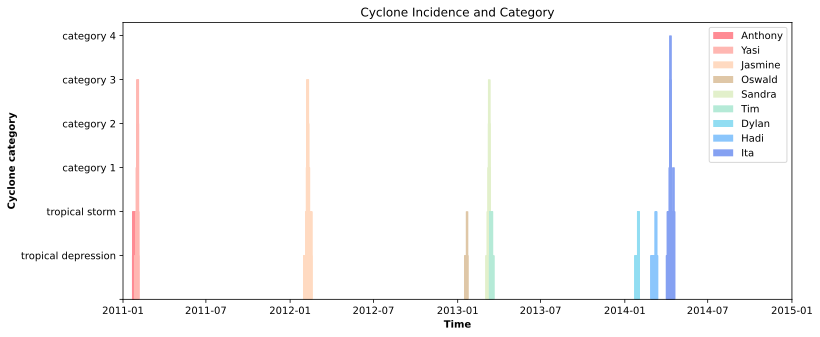

In [12]:
# Plotting the data
fig, ax1 = plt.subplots(figsize=(12, 5))

# Plotting cyclone category at each recorded time with different bar colour for each cyclone
ax1.bar(Anthony["ISO_TIME"], Anthony["CATEGORY"], color="#ff8b94", label='Anthony', align='center', width=5, zorder=0)
ax1.bar(Yasi["ISO_TIME"], Yasi["CATEGORY"], color="#FFB7B2", label='Yasi', align='center', width=5, zorder=0)
ax1.bar(Jasmine["ISO_TIME"], Jasmine["CATEGORY"], color="#FFDAC1", label='Jasmine', align='center', width=5, zorder=0)
ax1.bar(Oswald["ISO_TIME"], Oswald["CATEGORY"], color="#dfc7a7", label='Oswald', align='center', width=5, zorder=0)
ax1.bar(Sandra["ISO_TIME"], Sandra["CATEGORY"], color="#E2F0CB", label='Sandra', align='center', width=5, zorder=0)
ax1.bar(Tim["ISO_TIME"], Tim["CATEGORY"], color="#B5EAD7", label='Tim', align='center', width=5, zorder=0)
ax1.bar(Dylan["ISO_TIME"], Dylan["CATEGORY"], color="#91DDF2", label='Dylan', align='center', width=5, zorder=0)
ax1.bar(Hadi["ISO_TIME"], Hadi["CATEGORY"], color="#8BC6FC", label='Hadi', align='center', width=5, zorder=0)
ax1.bar(Ita["ISO_TIME"], Ita["CATEGORY"], color="#85A1F2", label='Ita', align='center', width=5, zorder=0)

ax1.set_ylabel("Cyclone category", weight='bold')
ax1.set_xlabel("Time", color="k", weight='bold')


plt.xlim([datetime.date(2011, 1, 1), datetime.date(2015, 1, 1)])


ax1.legend(loc=1)


plt.title('Cyclone Incidence and Category')
plt.savefig('Cyclone Incidence and Category', dpi=300, bbox_inches = "tight")
plt.show()

Plotting strandings before and after key cyclones:

In [16]:
dugong

,2014,2013,2012,2011,2010
Location,,,,,
Moreton Bay,7,7,6,16,14
Hervey Bay,1,5,6,19,6
Rockhampton,1,2,8,10,3
Mackay,1,0,1,4,1
Townsville,2,3,4,51,16
Cairns,0,2,5,11,16
Remainder of east coast,11,8,14,55,12


In [17]:
# Specifying columns to drop by index number to show only the data relevant to cyclone Yasi
cols = [0, 1, 2]

# Dropping, renaming columns, and switching column order to show the strandings before the cyclone first
dugongYasi = dugong.drop(dugong.columns[cols], axis=1)
dugongYasi.rename(columns={'2011': 'After Yasi', '2010': 'Before Yasi'}, inplace=True)
dugongYasi = dugongYasi.loc[:,['Before Yasi','After Yasi']]
dugongYasi

,Before Yasi,After Yasi
Location,,
Moreton Bay,14,16
Hervey Bay,6,19
Rockhampton,3,10
Mackay,1,4
Townsville,16,51
Cairns,16,11
Remainder of east coast,12,55


Plotting strandings before and after cyclone Yasi:

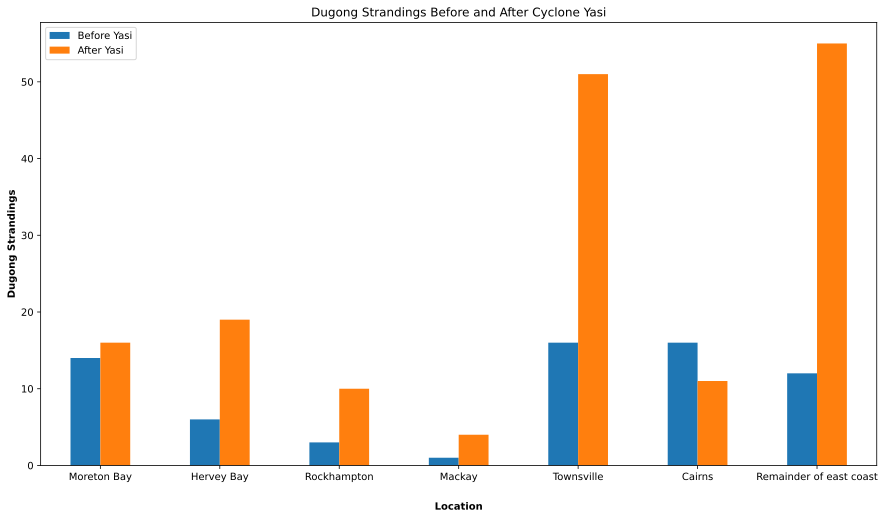

In [18]:
dugongYasi.plot(kind='bar', figsize=(15,8))
plt.title('Dugong Strandings Before and After Cyclone Yasi')
plt.xlabel('Location', labelpad=20, weight='bold')
plt.ylabel('Dugong Strandings', weight='bold')
plt.xticks(rotation=0)
plt.savefig('Dugong Strandings Before and After Cyclone Yasi', bbox_inches='tight', dpi=200)

Repeating this process for cyclones Ita and Oswald:

In [19]:
# Specifying columns to drop by index number to show only the data relevant to cyclone Yasi
cols = [2, 3, 4]

# Dropping, renaming columns, and switching column order to show the strandings before the cyclone first
dugongIta = dugong.drop(dugong.columns[cols], axis=1)
dugongIta.rename(columns={'2014': 'After Ita', '2013': 'Before Ita'}, inplace=True)
dugongIta = dugongIta.loc[:,['Before Ita','After Ita']]
dugongIta

,Before Ita,After Ita
Location,,
Moreton Bay,7,7
Hervey Bay,5,1
Rockhampton,2,1
Mackay,0,1
Townsville,3,2
Cairns,2,0
Remainder of east coast,8,11


Plotting strandings before and after cyclone Ita:

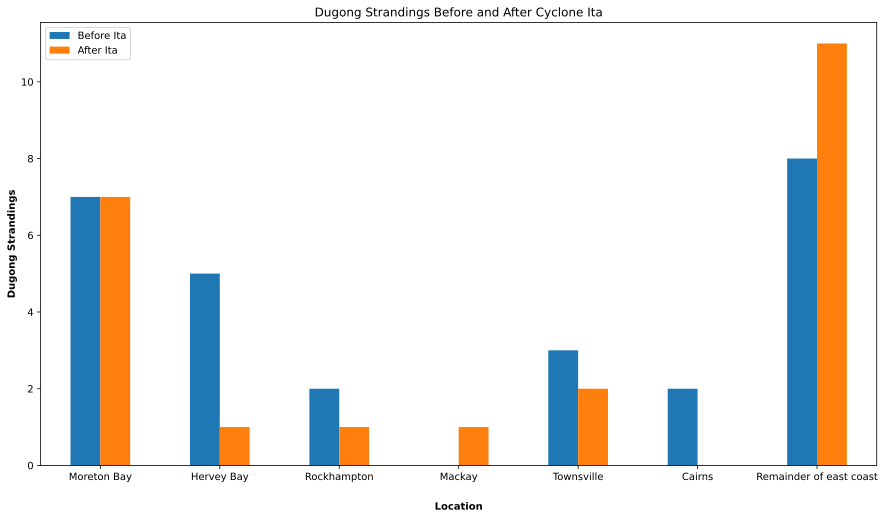

In [20]:
dugongIta.plot(kind='bar', figsize=(15,8))
plt.title('Dugong Strandings Before and After Cyclone Ita')
plt.xlabel('Location', labelpad=20, weight='bold')
plt.ylabel('Dugong Strandings', weight='bold')
plt.xticks(rotation=0)
plt.savefig('Dugong Strandings Before and After Cyclone Ita', bbox_inches='tight', dpi=200)

In [21]:
# Specifying columns to drop by index number to show only the data relevant to cyclone Yasi
cols = [0, 3, 4]

# Dropping, renaming columns, and switching column order to show the strandings before the cyclone first
dugongOswald = dugong.drop(dugong.columns[cols], axis=1)
dugongOswald.rename(columns={'2013': 'After Oswald', '2012': 'Before Oswald'}, inplace=True)
dugongOswald = dugongOswald.loc[:,['Before Oswald','After Oswald']]
dugongOswald

,Before Oswald,After Oswald
Location,,
Moreton Bay,6,7
Hervey Bay,6,5
Rockhampton,8,2
Mackay,1,0
Townsville,4,3
Cairns,5,2
Remainder of east coast,14,8


Plotting strandings before and after cyclone Oswald

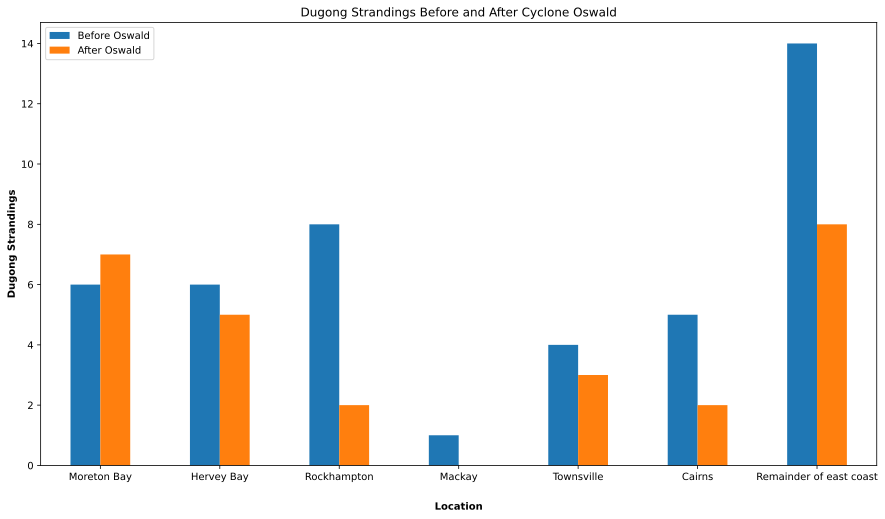

In [22]:
dugongOswald.plot(kind='bar', figsize=(15,8))
plt.title('Dugong Strandings Before and After Cyclone Oswald')
plt.xlabel('Location', labelpad=20, weight='bold')
plt.ylabel('Dugong Strandings', weight='bold')
plt.xticks(rotation=0)
plt.savefig('Dugong Strandings Before and After Cyclone Oswald', bbox_inches='tight', dpi=200)